# Section 5

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16
})

## Spectral function
Three Gaussians with parameters (position,width,weight) = (0,0.15,0.2),(±1,0.8,0.4).

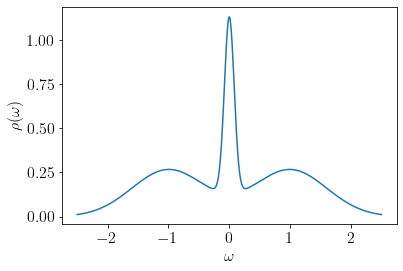

In [30]:
gaussian = lambda x, mu, sigma: np.exp(-0.5*((x-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.08) + \
    0.4*gaussian(omega, 1.0, 0.6) + 0.4*gaussian(omega, -1.0, 0.6)

omegas = np.linspace(-2.5, 2.5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))


## Imaginary-time Green's function

We transform the spectral function to the Green's function using
$$
G(\tau) = - \int_{-\omega_\mathrm{max}}^{\omega_\mathrm{max}}d\tau K(\tau, \omega) \rho(\omega),
$$
where
$$
K(\tau, \omega) = \frac{e^{-\tau\omega}}{1+e^{-\beta\omega}}.
$$

When we discretize the kernel on uniform meshs for $\tau$ and $\omega$,
we obtain
$$
G(\tau_i) = - \frac{2\omega_\mathrm{max}}{N_\omega} \sum_j K(\tau_i, \omega_j) \rho(\omega_j) 
$$
for $i=1,2,\cdots,N_\tau$ and $j=1,2,\cdots,N_\omega$.
The cut-off frequency $\omega_\mathrm{max}$ must be large enough.
In this example, we use $\omega_\mathrm{max}=10$.

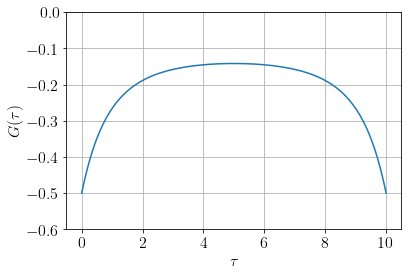

In [63]:
wmax = 10.0
beta = 10.0

nomega = 1000
ntau = 1000

omegas_mesh = np.linspace(-wmax, wmax, nomega)
taus_mesh = np.linspace(0, beta, ntau)

kernel = lambda tau, omega: np.exp(-tau*omega)/(1 + np.exp(-beta*omega))

kernel_val = kernel(taus_mesh[:,None], omegas_mesh[None,:])
gtau = - kernel_val @ rho(omegas_mesh) * (2*wmax/nomega)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$G(\tau)$')
plt.ylim([-0.6,0])
plt.grid()
plt.plot(taus_mesh, gtau)

In [56]:
print(gtau[0])

-0.5000000000000515


## Reconstruction of spectral function

Can we reconstruct the original $\rho(\omega)$?
You might use
$$
\rho(\omega_j) = - \frac{N_\omega}{2\omega_\mathrm{max}} \sum_i (K^{-1})_{ji} G(\tau_j)
$$

.

Text(0, 0.5, '$\\rho(\\omega)$')

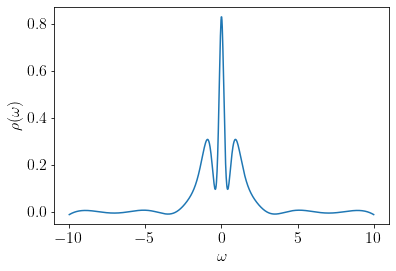

In [78]:
# OK, you get random data... (We actually used the pseudo inverse)
rho_reconst = -  (nomega/(2*wmax)) * np.linalg.pinv(kernel_val, rcond=1e-5) @ gtau
plt.plot(omegas_mesh, rho_reconst)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')

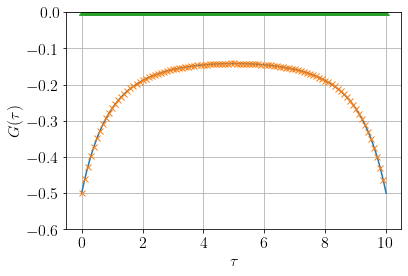

In [82]:
gtau_reconst = - kernel_val @ rho_reconst * (2*wmax/nomega)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$G(\tau)$')
plt.ylim([-0.6,0])
plt.grid()
plt.plot(taus_mesh, gtau)
plt.plot(taus_mesh[::10], gtau_reconst[::10], ls='', marker='x')

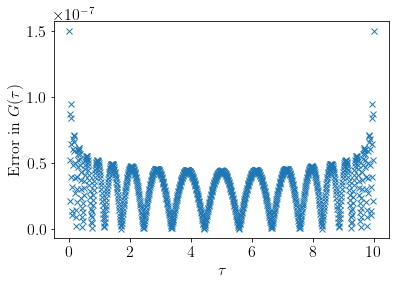

In [85]:
plt.xlabel(r'$\tau$')
plt.ylabel(r'Error in $G(\tau)$')
plt.plot(taus_mesh, np.abs(gtau-gtau_reconst), ls='', marker='x')

## Singular values

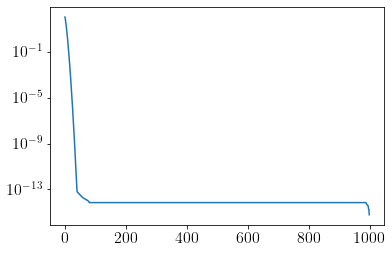

In [72]:
u, s, vh = np.linalg.svd(kernel_val)
plt.semilogy(s)